In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle
import keras.utils as utils
from sklearn import metrics
%matplotlib inline 

Using TensorFlow backend.
C:\Users\Guus\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Guus\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Guus\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Guus\Anaconda3\envs\PythonGPU

In [2]:
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

## Loading Data

In [3]:
filedir = ".\\data\\"
activities = ['cycling', 'driving', 'jogging', 'sleeping', 'walking']
epoch_length = 360

In [4]:
pickle_in = open(filedir+"data\\data.pickle","rb")
data_dict = pickle.load(pickle_in)
pickle_in.close()

In [5]:
X = data_dict["cnn_array"]

In [6]:
y = []
for item in data_dict["label"]:
    #value = 0
    if item == activities[0]:
        y.append(0)
    elif item == activities[1]:
        y.append(1)
    elif item == activities[2]:
        y.append(2)
    elif item == activities[3]:
        y.append(3)
    elif item == activities[4]:
        y.append(4)

## Train / Test Split 80/10/10

In [7]:
test_size = int(int(X.shape[0] * 0.1) / len(set(y))) * len(set(y))

In [8]:
from sklearn.model_selection import train_test_split
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=test_size, random_state=4091988, stratify=y)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=test_size, random_state=4091988, stratify=y_data)

In [10]:
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
y_val = utils.to_categorical(y_val)

## Novel CNN

In [11]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [12]:
verbose, epochs, batch_size = 1, 20, 32

In [13]:
## Model is from https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





In [14]:
model.fit(X_train, y_train, epochs = epochs, 
          validation_data = (X_val, y_val), 
          batch_size = batch_size, verbose=verbose)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 6520 samples, validate on 810 samples
Epoch 1/20
6520/6520 [==============================] - 3s 429us/step - loss: 0.4528 - acc: 0.8485 - val_loss: 0.3558 - val_acc: 0.9000
Epoch 2/20
6520/6520 [==============================] - 1s 105us/step - loss: 0.2819 - acc: 0.9121 - val_loss: 0.3273 - val_acc: 0.8988
Epoch 3/20
6520/6520 [==============================] - 1s 105us/step - loss: 0.2561 - acc: 0.9150 - val_loss: 0.2929 - val_acc: 0.8988
Epoch 4/20
6520/6520 [==============================] - 1s 106us/step - loss: 0.2299 - acc: 0.9245 - val_loss: 0.2936 - val_acc: 0.9012
Epoch 5/20
6520/6520 [==============================] - 1s 105us/step - loss: 0.2053 - acc: 0.9305 - val_loss: 0.2448 - val_acc: 0.9259
Epoch 6/20
6520/6520 [==============================] - 1s 105us/step - loss: 0.1943 - acc: 0.9314 - val_loss: 0.2597 - val_acc: 0.9148
Epoch 7/20
6520/6520 [====================

In [15]:
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
accuracy

0.9172839503229401

In [16]:
results = open("accuracy_base80.txt","w")
results.write(str(accuracy))
results.close()

In [17]:
y_pred = model.predict_classes(X_test)

In [18]:
print(metrics.classification_report(np.argmax(y_test,axis=1), y_pred, target_names = activities, digits = 4))

              precision    recall  f1-score   support

     cycling     0.8779    0.9321    0.9042       162
     driving     0.8043    0.9136    0.8555       162
     jogging     0.9759    1.0000    0.9878       162
    sleeping     1.0000    0.9259    0.9615       162
     walking     0.9565    0.8148    0.8800       162

    accuracy                         0.9173       810
   macro avg     0.9229    0.9173    0.9178       810
weighted avg     0.9229    0.9173    0.9178       810



In [19]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(np.argmax(y_test,axis=1), y_pred))

Confusion matrix:
[[151   8   0   0   3]
 [ 11 148   0   0   3]
 [  0   0 162   0   0]
 [  3   9   0 150   0]
 [  7  19   4   0 132]]


---

## Novel + Tuning Parameters

In [20]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [21]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [22]:
verbose, epochs, batch_size = 1, 1000, 64

In [23]:
## Model is from https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
model_novel = Sequential()
model_novel.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model_novel.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_novel.add(Dropout(0.5))
model_novel.add(MaxPooling1D(pool_size=2))
model_novel.add(Flatten())
model_novel.add(Dense(100, activation='relu'))
model_novel.add(Dense(n_outputs, activation='softmax'))
model_novel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=50)

mc = ModelCheckpoint('.\\data\\data\\best_model_novel_80.h5', monitor='val_acc', mode='max', verbose=verbose,
                     save_best_only=True)

history_novel = model_novel.fit(X_train, y_train, epochs = epochs, 
          validation_data = (X_val, y_val), 
          batch_size = batch_size, verbose=verbose,
                   callbacks=[es, mc])

Train on 6520 samples, validate on 810 samples
Epoch 1/1000
6520/6520 [==============================] - 1s 118us/step - loss: 0.5248 - acc: 0.8190 - val_loss: 0.4521 - val_acc: 0.8160

Epoch 00001: val_acc improved from -inf to 0.81605, saving model to .\data\data\best_model_novel_80.h5
Epoch 2/1000
6520/6520 [==============================] - 0s 65us/step - loss: 0.3074 - acc: 0.8991 - val_loss: 0.3446 - val_acc: 0.9123

Epoch 00002: val_acc improved from 0.81605 to 0.91235, saving model to .\data\data\best_model_novel_80.h5
Epoch 3/1000
6520/6520 [==============================] - 0s 64us/step - loss: 0.2726 - acc: 0.9107 - val_loss: 0.2886 - val_acc: 0.9086

Epoch 00003: val_acc did not improve from 0.91235
Epoch 4/1000
6520/6520 [==============================] - 0s 64us/step - loss: 0.2435 - acc: 0.9198 - val_loss: 0.3110 - val_acc: 0.9062

Epoch 00004: val_acc did not improve from 0.91235
Epoch 5/1000
6520/6520 [==============================] - 0s 63us/step - loss: 0.2324 - acc


Epoch 00042: val_acc did not improve from 0.93333
Epoch 43/1000
6520/6520 [==============================] - 0s 63us/step - loss: 0.0372 - acc: 0.9879 - val_loss: 0.3546 - val_acc: 0.9160

Epoch 00043: val_acc did not improve from 0.93333
Epoch 44/1000
6520/6520 [==============================] - 0s 63us/step - loss: 0.0313 - acc: 0.9906 - val_loss: 0.3445 - val_acc: 0.9185

Epoch 00044: val_acc did not improve from 0.93333
Epoch 45/1000
6520/6520 [==============================] - 0s 64us/step - loss: 0.0388 - acc: 0.9860 - val_loss: 0.3906 - val_acc: 0.9222

Epoch 00045: val_acc did not improve from 0.93333
Epoch 46/1000
6520/6520 [==============================] - 0s 64us/step - loss: 0.0394 - acc: 0.9867 - val_loss: 0.3474 - val_acc: 0.9210

Epoch 00046: val_acc did not improve from 0.93333
Epoch 47/1000
6520/6520 [==============================] - 0s 64us/step - loss: 0.0391 - acc: 0.9850 - val_loss: 0.3238 - val_acc: 0.9160

Epoch 00047: val_acc did not improve from 0.93333
Epoc

In [25]:
saved_model_novel = load_model('.\\data\\data\\best_model_novel_80.h5')

In [26]:
y_pred_novel = saved_model_novel.predict_classes(X_test)

In [27]:
_, accuracy_novel = saved_model_novel.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
accuracy_novel

810/810 [==============================] - 0s 74us/sample - loss: 0.3952 - acc: 0.9272


0.9271605

In [28]:
print(metrics.classification_report(np.argmax(y_test,axis=1), y_pred_novel, target_names = activities, digits = 4))

              precision    recall  f1-score   support

     cycling     0.9286    0.8827    0.9051       162
     driving     0.8197    0.9259    0.8696       162
     jogging     0.9701    1.0000    0.9848       162
    sleeping     0.9936    0.9630    0.9781       162
     walking     0.9396    0.8642    0.9003       162

    accuracy                         0.9272       810
   macro avg     0.9303    0.9272    0.9276       810
weighted avg     0.9303    0.9272    0.9276       810



In [29]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(np.argmax(y_test,axis=1), y_pred_novel))

Confusion matrix:
[[143  16   0   0   3]
 [  5 150   1   1   5]
 [  0   0 162   0   0]
 [  0   5   0 156   1]
 [  6  12   4   0 140]]


In [30]:
results = open("accuracy_novel80.txt","w")
results.write(str(accuracy_novel))
results.close()

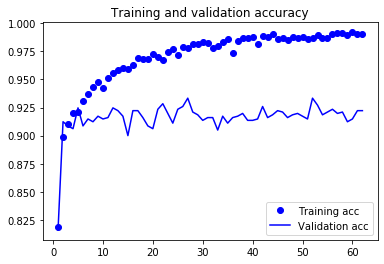

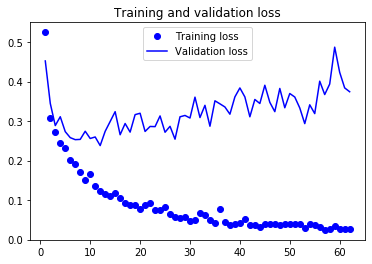

In [31]:
acc = history_novel.history['acc']

val_acc = history_novel.history['val_acc']
loss = history_novel.history['loss']
val_loss = history_novel.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.savefig('novel80_graph'+str(1)+'.png')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.savefig('novel80_graph'+str(2)+'.png')
plt.legend()

plt.show()

---

## ResNet CNN Architecture

In [32]:
import keras as keras
import tensorflow as tf

In [33]:
verbose, epochs, batch_size = 1, 1000, 64

In [34]:
## Architecture is from https://github.com/hfawaz/dl-4-tsc/blob/master/classifiers/resnet.py
n_feature_maps = 64

input_layer = keras.layers.Input(shape = (n_timesteps,n_features))

# BLOCK 1

conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_1 = keras.layers.add([shortcut_y, conv_z])
output_block_1 = keras.layers.Activation('relu')(output_block_1)

# BLOCK 2

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_2 = keras.layers.add([shortcut_y, conv_z])
output_block_2 = keras.layers.Activation('relu')(output_block_2)

# BLOCK 3

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# no need to expand channels because they are equal
shortcut_y = keras.layers.BatchNormalization()(output_block_2)

output_block_3 = keras.layers.add([shortcut_y, conv_z])
output_block_3 = keras.layers.Activation('relu')(output_block_3)

# FINAL

gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

output_layer = keras.layers.Dense(n_outputs, activation='softmax')(gap_layer)

model_resnet = keras.models.Model(inputs=input_layer, outputs=output_layer)

model_resnet.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=50)

mc = ModelCheckpoint('.\\data\\data\\best_model_resnet_80.h5', monitor='val_acc', mode='max', verbose=verbose,
                     save_best_only=True)

history_resnet = model_resnet.fit(X_train, y_train, epochs = 1000, 
          validation_data = (X_val, y_val), 
          batch_size = batch_size, verbose=verbose,
                   callbacks=[es, mc])

Train on 6520 samples, validate on 810 samples
Epoch 1/1000
6520/6520 [==============================] - 6s 904us/step - loss: 0.3951 - acc: 0.8698 - val_loss: 0.3327 - val_acc: 0.8914

Epoch 00001: val_acc improved from -inf to 0.89136, saving model to .\data\data\best_model_resnet_80.h5
Epoch 2/1000
6520/6520 [==============================] - 3s 502us/step - loss: 0.2990 - acc: 0.8971 - val_loss: 0.3331 - val_acc: 0.8938

Epoch 00002: val_acc improved from 0.89136 to 0.89383, saving model to .\data\data\best_model_resnet_80.h5
Epoch 3/1000
6520/6520 [==============================] - 3s 495us/step - loss: 0.2758 - acc: 0.9072 - val_loss: 0.2627 - val_acc: 0.9074

Epoch 00003: val_acc improved from 0.89383 to 0.90741, saving model to .\data\data\best_model_resnet_80.h5
Epoch 4/1000
6520/6520 [==============================] - 3s 495us/step - loss: 0.2600 - acc: 0.9135 - val_loss: 0.2581 - val_acc: 0.9062

Epoch 00004: val_acc did not improve from 0.90741
Epoch 5/1000
6520/6520 [=====

6520/6520 [==============================] - 3s 497us/step - loss: 0.1012 - acc: 0.9627 - val_loss: 0.1599 - val_acc: 0.9481

Epoch 00041: val_acc did not improve from 0.95679
Epoch 42/1000
6520/6520 [==============================] - 3s 497us/step - loss: 0.0955 - acc: 0.9640 - val_loss: 0.1642 - val_acc: 0.9432

Epoch 00042: val_acc did not improve from 0.95679
Epoch 43/1000
6520/6520 [==============================] - 3s 501us/step - loss: 0.0895 - acc: 0.9656 - val_loss: 0.1616 - val_acc: 0.9494

Epoch 00043: val_acc did not improve from 0.95679
Epoch 44/1000
6520/6520 [==============================] - 3s 495us/step - loss: 0.0986 - acc: 0.9637 - val_loss: 0.1458 - val_acc: 0.9519

Epoch 00044: val_acc did not improve from 0.95679
Epoch 45/1000
6520/6520 [==============================] - 3s 500us/step - loss: 0.0917 - acc: 0.9664 - val_loss: 0.1444 - val_acc: 0.9531

Epoch 00045: val_acc did not improve from 0.95679
Epoch 46/1000
6520/6520 [==============================] - 3s 49

6520/6520 [==============================] - 3s 497us/step - loss: 0.0402 - acc: 0.9842 - val_loss: 0.1539 - val_acc: 0.9506

Epoch 00083: val_acc did not improve from 0.96049
Epoch 84/1000
6520/6520 [==============================] - 3s 497us/step - loss: 0.0557 - acc: 0.9813 - val_loss: 0.1739 - val_acc: 0.9556

Epoch 00084: val_acc did not improve from 0.96049
Epoch 85/1000
6520/6520 [==============================] - 3s 502us/step - loss: 0.0470 - acc: 0.9839 - val_loss: 0.1684 - val_acc: 0.9580

Epoch 00085: val_acc did not improve from 0.96049
Epoch 86/1000
6520/6520 [==============================] - 3s 497us/step - loss: 0.0466 - acc: 0.9833 - val_loss: 0.1588 - val_acc: 0.9617

Epoch 00086: val_acc improved from 0.96049 to 0.96173, saving model to .\data\data\best_model_resnet_80.h5
Epoch 87/1000
6520/6520 [==============================] - 3s 497us/step - loss: 0.0513 - acc: 0.9813 - val_loss: 0.2068 - val_acc: 0.9543

Epoch 00087: val_acc did not improve from 0.96173
Epoch 8

6520/6520 [==============================] - 3s 500us/step - loss: 0.0268 - acc: 0.9905 - val_loss: 0.1842 - val_acc: 0.9617

Epoch 00125: val_acc did not improve from 0.96790
Epoch 126/1000
6520/6520 [==============================] - 3s 489us/step - loss: 0.0221 - acc: 0.9905 - val_loss: 0.1650 - val_acc: 0.9642

Epoch 00126: val_acc did not improve from 0.96790
Epoch 127/1000
6520/6520 [==============================] - 3s 487us/step - loss: 0.0269 - acc: 0.9888 - val_loss: 0.2143 - val_acc: 0.9630

Epoch 00127: val_acc did not improve from 0.96790
Epoch 128/1000
6520/6520 [==============================] - 3s 486us/step - loss: 0.0258 - acc: 0.9891 - val_loss: 0.2079 - val_acc: 0.9617

Epoch 00128: val_acc did not improve from 0.96790
Epoch 129/1000
6520/6520 [==============================] - 3s 489us/step - loss: 0.0361 - acc: 0.9854 - val_loss: 0.2136 - val_acc: 0.9506

Epoch 00129: val_acc did not improve from 0.96790
Epoch 130/1000
6520/6520 [==============================] - 

In [36]:
saved_model_resnet = load_model('.\\data\\data\\best_model_resnet_80.h5')

In [37]:
y_pred_resnet = np.argmax(saved_model_resnet.predict(X_test), axis=1)

In [38]:
_, accuracy_resnet = saved_model_resnet.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
accuracy_resnet

810/810 [==============================] - 0s 382us/sample - loss: 0.1797 - acc: 0.9704


0.97037035

In [39]:
print(metrics.classification_report(np.argmax(y_test,axis=1), y_pred_resnet, target_names = activities, digits = 4))

              precision    recall  f1-score   support

     cycling     0.9515    0.9691    0.9602       162
     driving     0.9329    0.9444    0.9387       162
     jogging     1.0000    1.0000    1.0000       162
    sleeping     0.9816    0.9877    0.9846       162
     walking     0.9872    0.9506    0.9686       162

    accuracy                         0.9704       810
   macro avg     0.9706    0.9704    0.9704       810
weighted avg     0.9706    0.9704    0.9704       810



In [40]:
results = open("accuracy_resnet80.txt","w")
results.write(str(accuracy_resnet))
results.close()

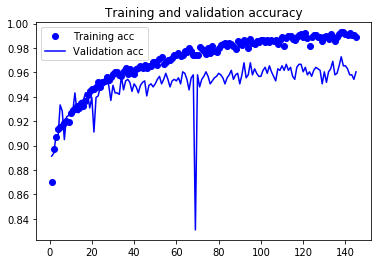

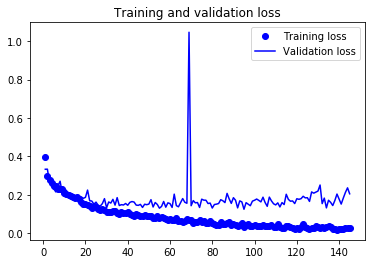

In [41]:
acc = history_resnet.history['acc']

val_acc = history_resnet.history['val_acc']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.savefig('resnet80_graph'+str(1)+'.png')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.savefig('resnet80_graph'+str(2)+'.png')
plt.legend()

plt.show()

---